## Connect google drive

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
final_spotify_data_cleaned = 'https://drive.google.com/file/d/1sfl8emc1NjjVd9TpuTHFdpUjJ-rCG_Jn/view?usp=share_link'

# link for final_spotify_data
# link = 'https://drive.google.com/file/d/1djViZyjX3-kNZbsY_nf-xovKDioIGpBU/view?usp=share_link'  
 
# to get the id part of the file
id = final_spotify_data_cleaned.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('final_spotify_data_cleaned.csv') 

## Load a dataset

In [ ]:
import pandas as pd 

df = pd.read_csv('final_spotify_data_cleaned.csv')
print(df.shape)
df.head()

(676345, 18)


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,total_available_markets,release_date,topartist_id,key,mode,time_signature,artist_genre
0,100,0.72100,0.585,242014.0,0.436,0.000013,0.1050,-8.761,0.0601,143.874,0.132,1.0,722.0,1McMsnEElThX1knmY4oliG,10.0,1.0,4.0,pop
1,96,0.02120,0.680,215627.0,0.826,0.000012,0.5430,-5.487,0.0309,118.051,0.644,184.0,1016.0,1Xyo4u8uXC1ZmMpatF05PJ,0.0,1.0,4.0,canadian contemporary r&b
2,96,0.00146,0.514,200040.0,0.730,0.000095,0.0897,-5.934,0.0598,171.005,0.334,184.0,1016.0,1Xyo4u8uXC1ZmMpatF05PJ,1.0,1.0,4.0,canadian contemporary r&b
3,95,0.22100,0.700,140526.0,0.722,0.000000,0.2720,-3.558,0.0369,90.989,0.756,0.0,890.0,6fWVd57NKTalqvmjRd2t8Z,7.0,0.0,4.0,cali rap
4,94,0.21300,0.662,161385.0,0.413,0.000000,0.1340,-7.357,0.0299,93.005,0.467,0.0,785.0,2tIP7SsRs7vjIcLrU85W8J,0.0,1.0,4.0,australian hip hop


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676345 entries, 0 to 676344
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   popularity               676345 non-null  int64  
 1   acousticness             676345 non-null  float64
 2   danceability             676345 non-null  float64
 3   duration_ms              676345 non-null  float64
 4   energy                   676345 non-null  float64
 5   instrumentalness         676345 non-null  float64
 6   liveness                 676345 non-null  float64
 7   loudness                 676345 non-null  float64
 8   speechiness              676345 non-null  float64
 9   tempo                    676345 non-null  float64
 10  valence                  676345 non-null  float64
 11  total_available_markets  676345 non-null  float64
 12  release_date             676345 non-null  float64
 13  topartist_id             676345 non-null  object 
 14  key 

In [ ]:
df.isnull().sum()

popularity                      0
acousticness                    0
danceability                    0
duration_ms                     0
energy                          0
instrumentalness                0
liveness                        0
loudness                        0
speechiness                     0
tempo                           0
valence                         0
total_available_markets         0
release_date                    0
topartist_id                    0
key                             0
mode                            0
time_signature                  0
artist_genre               164869
dtype: int64

## Down sampling

In [ ]:
# sub-sampling popularity
df['popularity'].value_counts(sort=True)

0      74548
21     12254
22     12159
23     11999
26     11886
       ...  
96         5
100        3
97         3
98         2
99         2
Name: popularity, Length: 101, dtype: int64

<Axes: >

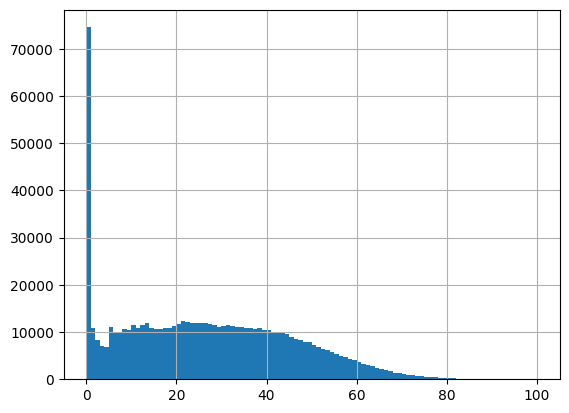

In [ ]:
df['popularity'].hist(bins=100)

<Axes: >

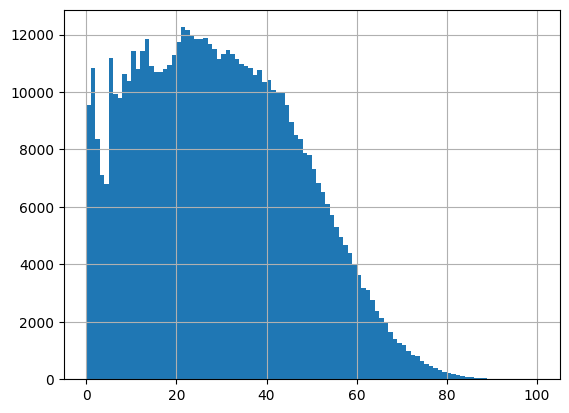

In [ ]:
df_sub = df.drop(df[df['popularity'] == 0].sample(n=65000, random_state=42).index)
df_sub['popularity'].hist(bins=100)

Text(0.5, 0, 'Popularity')

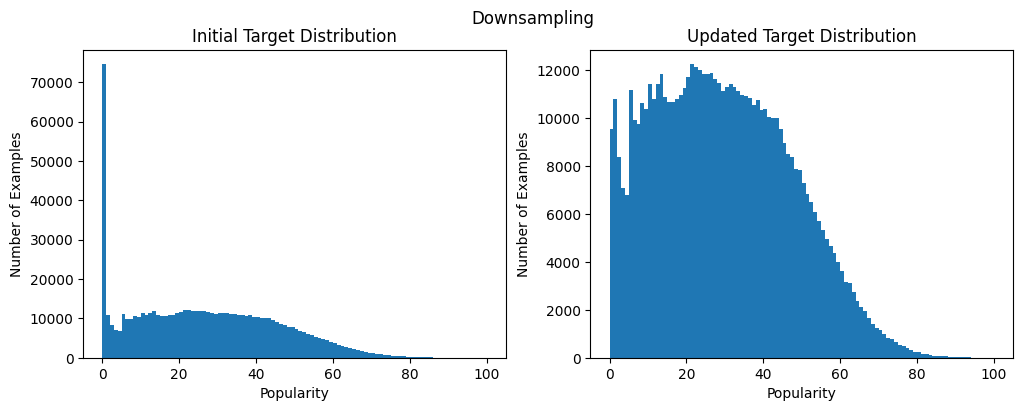

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

fig.suptitle("Downsampling")

ax1.set_title("Initial Target Distribution")
ax1.hist(df['popularity'], bins=100)
ax1.set_ylabel("Number of Examples")
ax1.set_xlabel("Popularity")

ax2.set_title("Updated Target Distribution")
ax2.hist(df_sub['popularity'], bins=100)
ax2.set_ylabel("Number of Examples")
ax2.set_xlabel("Popularity")
ax2.ylim([0, 80000])

In [ ]:
from sklearn.model_selection import train_test_split

X = df_sub.drop('popularity', axis=1)
y = df_sub['popularity']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25)

print("{:<7}: {}".format('X_train', X_train.shape))
print("{:<7}: {}".format('X_val', X_val.shape))
print("{:<7}: {}".format('X_test', X_test.shape))

X_train: (366807, 17)
X_val  : (122269, 17)
X_test : (122269, 17)


## Sparse Data Check

Text(0.5, 0, '% populated')

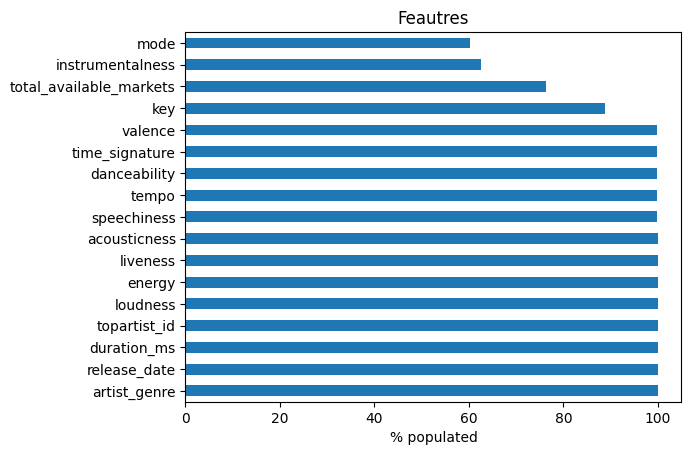

In [ ]:
import numpy as np

# check sparse data
sparsity = pd.Series(np.count_nonzero(X, axis=0)*100/ X.shape[0], index = X.columns)

sparse_filtered = sparsity.sort_values(ascending=False)
ax = sparse_filtered.plot.barh(title='Feautres')
ax.set_xlabel('% populated')

## Make a buket 

In [ ]:
import numpy as np

conditions = [
    (df['popularity'] <= 20),
    (df['popularity'] > 20) & (df['popularity'] <= 40),
    (df['popularity'] > 40) & (df['popularity'] <= 60),
    (df['popularity'] > 60) & (df['popularity'] <= 80),
    (df['popularity'] > 80)
    ]

values = [1, 2, 3, 4, 5]

df['popularity_bucket'] = np.select(conditions, values)

# display updated DataFrame
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,total_available_markets,release_date,topartist_id,key,mode,time_signature,artist_genre,popularity_bucket
0,100,0.72100,0.585,242014.0,0.436,0.000013,0.1050,-8.761,0.0601,143.874,0.132,1.0,722.0,1McMsnEElThX1knmY4oliG,10.0,1.0,4.0,pop,5
1,96,0.02120,0.680,215627.0,0.826,0.000012,0.5430,-5.487,0.0309,118.051,0.644,184.0,1016.0,1Xyo4u8uXC1ZmMpatF05PJ,0.0,1.0,4.0,canadian contemporary r&b,5
2,96,0.00146,0.514,200040.0,0.730,0.000095,0.0897,-5.934,0.0598,171.005,0.334,184.0,1016.0,1Xyo4u8uXC1ZmMpatF05PJ,1.0,1.0,4.0,canadian contemporary r&b,5
3,95,0.22100,0.700,140526.0,0.722,0.000000,0.2720,-3.558,0.0369,90.989,0.756,0.0,890.0,6fWVd57NKTalqvmjRd2t8Z,7.0,0.0,4.0,cali rap,5
4,94,0.21300,0.662,161385.0,0.413,0.000000,0.1340,-7.357,0.0299,93.005,0.467,0.0,785.0,2tIP7SsRs7vjIcLrU85W8J,0.0,1.0,4.0,australian hip hop,5


In [ ]:
df['popularity_bucket'].value_counts(sort=True)

1    282111
2    226354
3    140590
4     26450
5       840
Name: popularity_bucket, dtype: int64

In [ ]:
conditions = [
    (df['popularity'] <= 30),
    (df['popularity'] > 30) & (df['popularity'] <= 70),
    (df['popularity'] > 70)
    ]

values = [1, 2, 3]

df['popularity_bucket'] = np.select(conditions, values)

df['popularity_bucket'].value_counts(sort=True)

1    399707
2    270360
3      6278
Name: popularity_bucket, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['popularity', 'popularity_bucket'], axis=1)
y = df['popularity_bucket']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25)

print("{:<7}: {}".format('X_train', X_train.shape))
print("{:<7}: {}".format('X_val', X_val.shape))
print("{:<7}: {}".format('X_test', X_test.shape))

X_train: (405807, 17)
X_val  : (135269, 17)
X_test : (135269, 17)


## Split a dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('popularity', axis=1)
y = df['popularity']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25)

print("{:<7}: {}".format('X_train', X_train.shape))
print("{:<7}: {}".format('X_val', X_val.shape))
print("{:<7}: {}".format('X_test', X_test.shape))

X_train: (405807, 17)
X_val  : (135269, 17)
X_test : (135269, 17)


## Target Encoding

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 6.8 MB/s eta 0:00:00


In [ ]:
from category_encoders import TargetEncoder

features_te = ['topartist_id', 'artist_genre']

te = TargetEncoder(cols=features_te, handle_missing='return_nan').fit(X_train, y_train)

X_train = te.transform(X_train)
X_val = te.transform(X_val)
X_test = te.transform(X_test)

X_train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,total_available_markets,release_date,topartist_id,key,mode,time_signature,artist_genre
213776,0.9930,0.438,195210.0,0.0723,0.824000,0.1160,-19.588,0.0371,160.032,0.470,185.0,872.0,1.364293,5.0,1.0,4.0,NaN
121756,0.1950,0.797,290200.0,0.5980,0.000006,0.0979,-10.160,0.2010,90.577,0.650,184.0,8819.0,1.597013,5.0,0.0,4.0,NaN
514557,0.0705,0.367,302680.0,0.4690,0.017900,0.1180,-8.293,0.0275,175.128,0.280,185.0,1191.0,1.652031,7.0,1.0,4.0,1.621053
586001,0.3110,0.580,168093.0,0.6780,0.000000,0.2550,-7.001,0.1640,135.546,0.344,184.0,1478.0,1.501227,1.0,0.0,4.0,1.432424
310292,0.3930,0.576,185347.0,0.8680,0.000000,0.9670,-1.497,0.0503,144.688,0.820,0.0,1268.0,1.359376,0.0,1.0,3.0,1.150196


## KNN to handle missing values

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5).fit(X_train.sample(frac=0.1))
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
# Confirm null values
X_train.isnull().sum()

acousticness               0
danceability               0
duration_ms                0
energy                     0
instrumentalness           0
liveness                   0
loudness                   0
speechiness                0
tempo                      0
valence                    0
total_available_markets    0
release_date               0
topartist_id               0
key                        0
mode                       0
time_signature             0
artist_genre               0
dtype: int64

## Check correlated features

<Axes: >

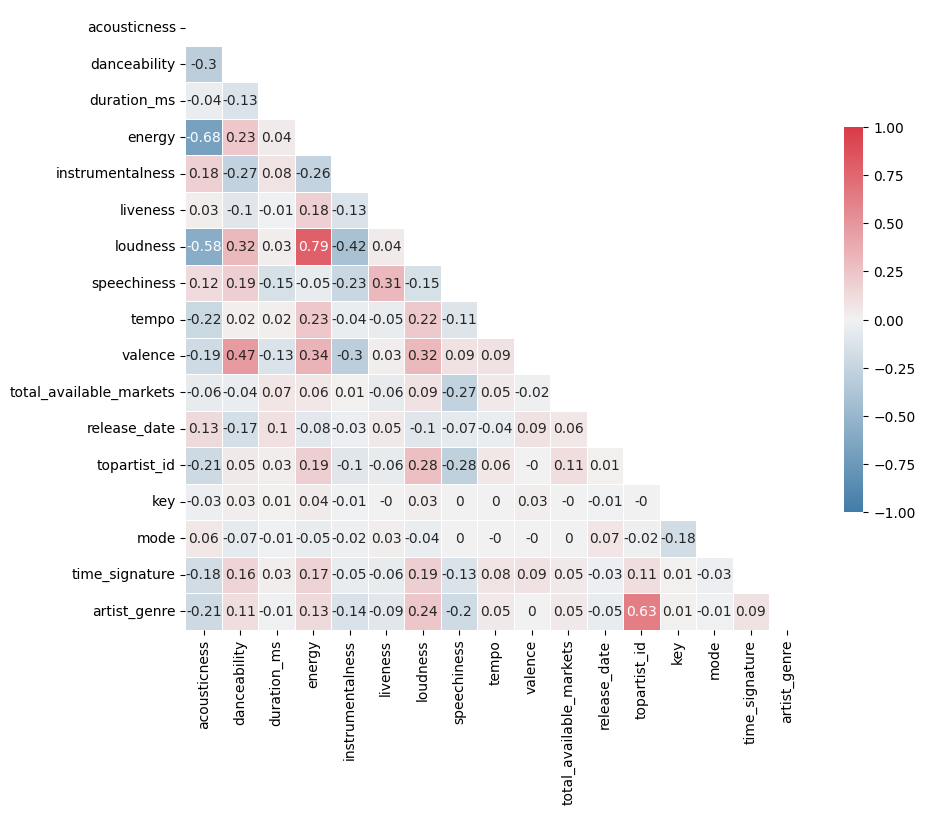

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(240, 10, as_cmap=True, n=20)
sns.heatmap(corr.round(2), mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## MinMaxScaler to normalize values 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)   # Fit and transform scalar on X_train
X_val = scaler.transform(X_val)           # Transform X_val
X_test = scaler.transform(X_test)         # Transform X_test

## Sampling

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print("Original Dataset shape: {:>18}".format(str(X_train.shape)))

ros = RandomOverSampler(random_state=42)
X_oversample, y_oversample = ros.fit_resample(X_train, y_train)

print("Dataset shape after sampling: {}".format(str(X_oversample.shape)))
print("")
print("Labels Distribution after sampling:")

Original Dataset shape:       (405807, 17)
Dataset shape after sampling: (718878, 17)

Labels Distribution after sampling:


<Axes: >

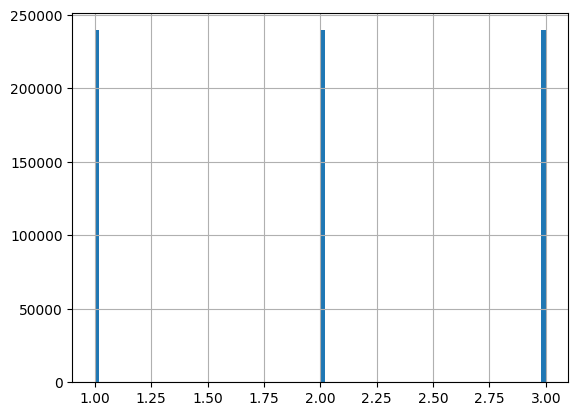

In [ ]:
y_oversample.hist(bins=100)

In [ ]:
### Not to use for now

# SMOTE
from imblearn.over_sampling import SMOTE

# Your Code Here
print("Original Dataset shape: {:>18}".format(str(X_train.shape)))

smote = SMOTE(random_state=42, k_neighbors=2)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Dataset shape after sampling: {}".format(str(X_train.shape)))
print("")
print("Labels Distribution after sampling:")
y_train.value_counts()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

vanilla_rr = RandomForestRegressor().fit(X_oversample, y_oversample)

print("{:<15} {}".format('Train R^2:', round(vanilla_rr.score(X_oversample, y_oversample),4)))
print("{} {}".format('Validation R^2:', round(vanilla_rr.score(X_val, y_val),4)))
print("{:<15} {}".format('Test R^2:', round(vanilla_rr.score(X_test, y_test),4)))
print("{:<15} {}".format('MSE Score:', round(mean_squared_error(y_test, vanilla_rr.predict(X_test)),4)))

Train R^2:      0.9956
Validation R^2: 0.5751
Test R^2:       0.5762


NameError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error

print("{:<15} {}".format('Train R^2:', round(vanilla_rr.score(X_oversample, y_oversample),4)))
print("{} {}".format('Validation R^2:', round(vanilla_rr.score(X_val, y_val),4)))
print("{:<15} {}".format('Test R^2:', round(vanilla_rr.score(X_test, y_test),4)))
print("{:<15} {}".format('MSE Score:', round(mean_squared_error(y_test, vanilla_rr.predict(X_test)),4)))

Train R^2:      0.9956
Validation R^2: 0.5751
Test R^2:       0.5762
MSE Score:      131.3336


In [ ]:
# 5 buckets
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10)#, max_features=5)
rf.fit(X_oversample, y_oversample)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

Accuracy: 0.555323096940171


0.5742930744453605

In [ ]:
# 3 buckets
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10)#, max_features=5)
rf.fit(X_oversample, y_oversample)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

Accuracy: 0.6629678640338881


0.6948107071844585

## Three Classification

## Add bias (skip)

In [ ]:
#Add a column of ones to the feature matrices
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [ ]:
feature_columns = list(X.columns)
feature_columns.insert(0, "bias")
feature_columns

['bias',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'total_available_markets',
 'release_date',
 'topartist_id',
 'key',
 'mode',
 'time_signature',
 'artist_genre']

## Box Cox Transformation

<ipython-input-83-2acf5885ca45>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, hist=False, kde=True)


<Axes: xlabel='popularity', ylabel='Density'>

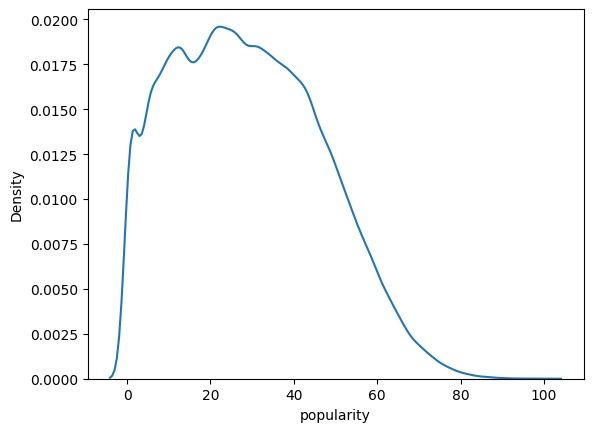

In [ ]:
from scipy.stats import boxcox

sns.distplot(y_train, hist=False, kde=True) 

<ipython-input-84-f09c890442a2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, hist=False, kde=True)


<Axes: ylabel='Density'>

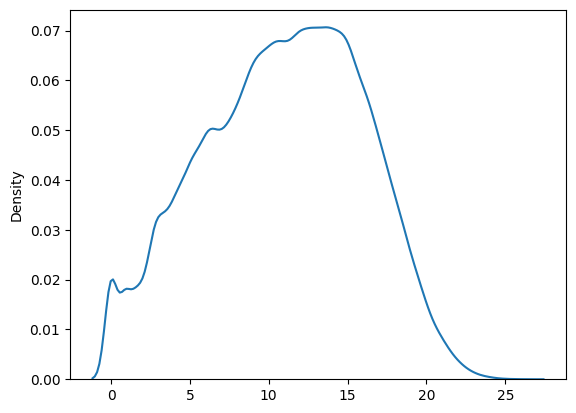

In [ ]:
transformed_data, best_lambda = boxcox(y_train[y_train>0])
sns.distplot(transformed_data, hist=False, kde=True) 

## YeoJohnsonTransformer

In [ ]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 22.4 MB/s eta 0:00:00


<Axes: >

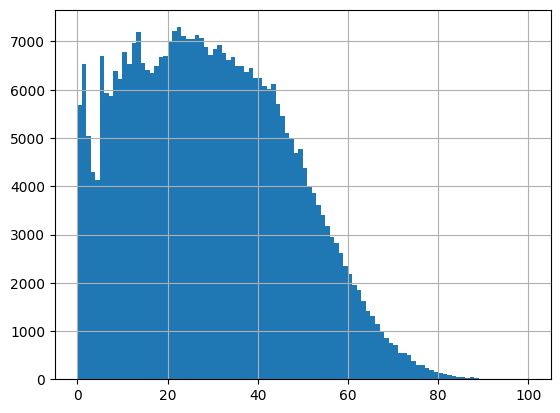

In [ ]:
y_train.hist(bins=100)

array([[<Axes: title={'center': 'popularity'}>]], dtype=object)

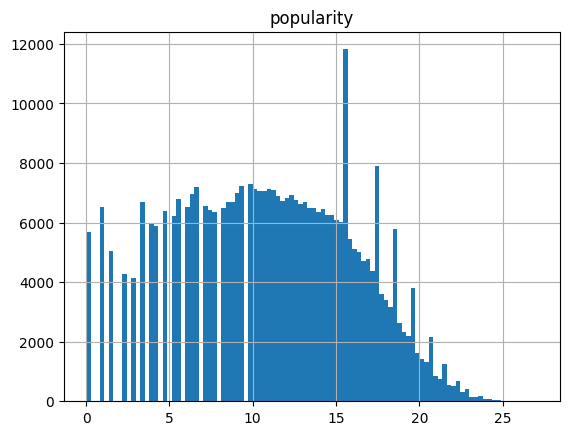

In [ ]:
# YeoJohnsonTransformer
#from feature_engine import variable_transformers as vt
from feature_engine import transformation as vt

tf = vt.YeoJohnsonTransformer(variables = ['popularity'])
#tf.fit(y_train.to_frame())

y_transform = tf.fit_transform(y_train.to_frame())
y_transform_val = tf.transform(y_val.to_frame())
y_transform_test = tf.transform(y_test.to_frame())
y_transform.hist(bins=100)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV

vanilla_rr = RandomForestRegressor().fit(X_train, y_transform)

print("{:<15} {}".format('Train R^2:', round(vanilla_rr.score(X_train, y_transform),4)))
print("{} {}".format('Validation R^2:', round(vanilla_rr.score(X_val, y_transform_val),4)))
print("{:<15} {}".format('Test R^2:', round(vanilla_rr.score(X_test, y_transform_test),4)))
print("{:<15} {}".format('MSE Score:', round(mean_squared_error(y_transform_test, vanilla_rr.predict(X_test)),4)))

<ipython-input-37-7aeef6cb53d7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  vanilla_rr = RandomForestRegressor().fit(X_train, y_transform)


Train R^2:      0.9714
Validation R^2: 0.5704
Test R^2:       0.571
MSE Score:      11.6093


## Log Transform

array([[<Axes: title={'center': 'popularity'}>]], dtype=object)

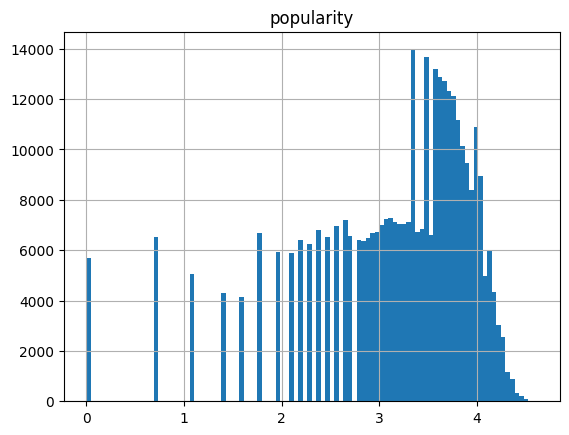

In [ ]:
from feature_engine import transformation as vt

tf = vt.LogCpTransformer(variables = ['popularity'])

y_transform_log = tf.fit_transform(y_train.to_frame())
y_transform_log_val = tf.transform(y_val.to_frame())
y_transform_log_test = tf.transform(y_test.to_frame())
y_transform_log.hist(bins=100)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

vanilla_rr = RandomForestRegressor().fit(X_train, y_transform_log)

print("{:<15} {}".format('Train R^2:', round(vanilla_rr.score(X_train, y_transform_log),4)))
print("{} {}".format('Validation R^2:', round(vanilla_rr.score(X_val, y_transform_log_val),4)))
print("{:<15} {}".format('Test R^2:', round(vanilla_rr.score(X_test, y_transform_log_test),4)))
print("{:<15} {}".format('MSE Score:', round(mean_squared_error(y_transform_log_test, vanilla_rr.predict(X_test)),4)))

<ipython-input-41-54762b1d47a4>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  vanilla_rr = RandomForestRegressor().fit(X_train, y_transform_log)


Train R^2:      0.9747
Validation R^2: 0.5022
Test R^2:       0.5007
MSE Score:      0.3752


## Train a model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
vanilla_rr = RandomForestRegressor().fit(X_train, y_train)

## Visualize a tree

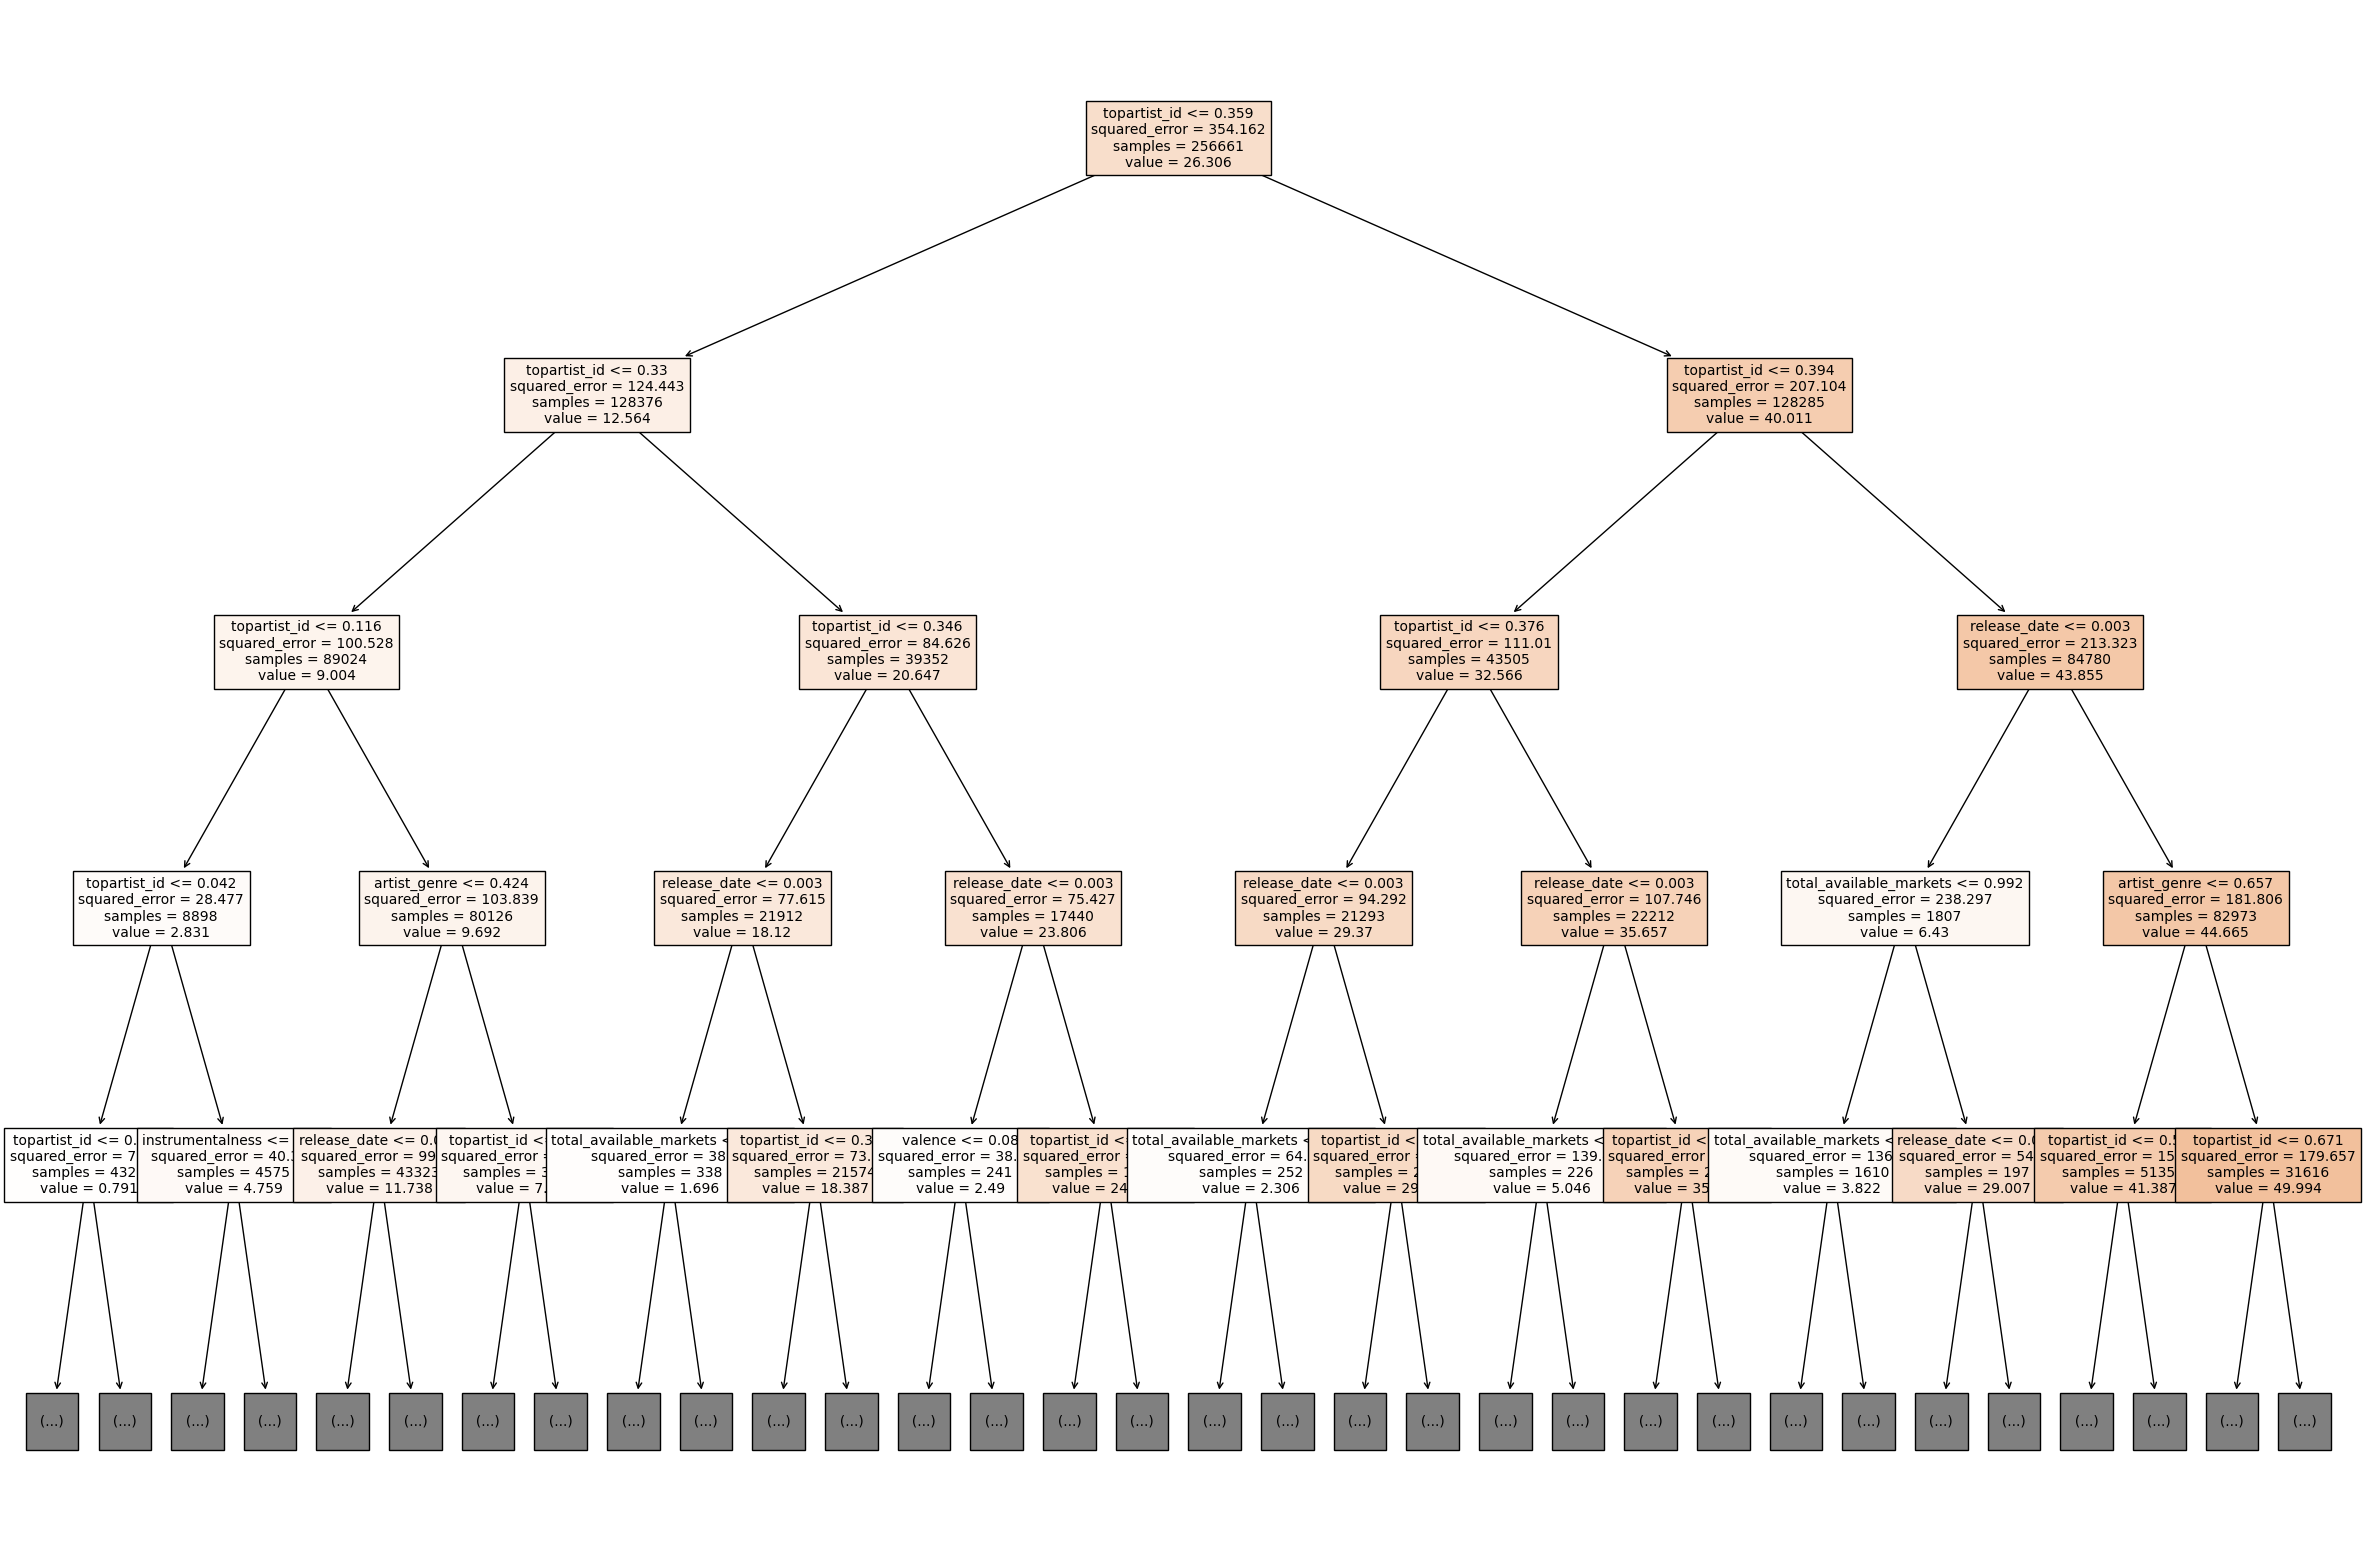

In [ ]:
fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(vanilla_rr.estimators_[0], max_depth=4, 
                   feature_names=feature_columns,
                   fontsize=10,
                   filled=True)

## Evaluate a model

In [ ]:
print("{:<15} {}".format('Train R^2:', round(vanilla_rr.score(X_train, y_train),4)))
print("{} {}".format('Validation R^2:', round(vanilla_rr.score(X_val, y_val),4)))
print("{:<15} {}".format('Test R^2:', round(vanilla_rr.score(X_test, y_test),4)))
print("{:<15} {}".format('MSE Score:', round(mean_squared_error(y_test, vanilla_rr.predict(X_test)),4)))

Train R^2:      0.9686
Validation R^2: 0.5904
Test R^2:       0.5925
MSE Score:      126.1718


In [ ]:
feature_columns = list(X.columns)
feature_columns

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'total_available_markets',
 'release_date',
 'topartist_id',
 'key',
 'mode',
 'time_signature',
 'artist_genre']

## Feature Imporatances

topartist_id               0.682841
release_date               0.058088
artist_genre               0.043953
duration_ms                0.021629
speechiness                0.020764
liveness                   0.020241
loudness                   0.020139
danceability               0.019124
acousticness               0.018162
valence                    0.017902
energy                     0.017053
tempo                      0.016941
total_available_markets    0.016907
instrumentalness           0.014223
key                        0.008603
mode                       0.001841
time_signature             0.001589
dtype: float64


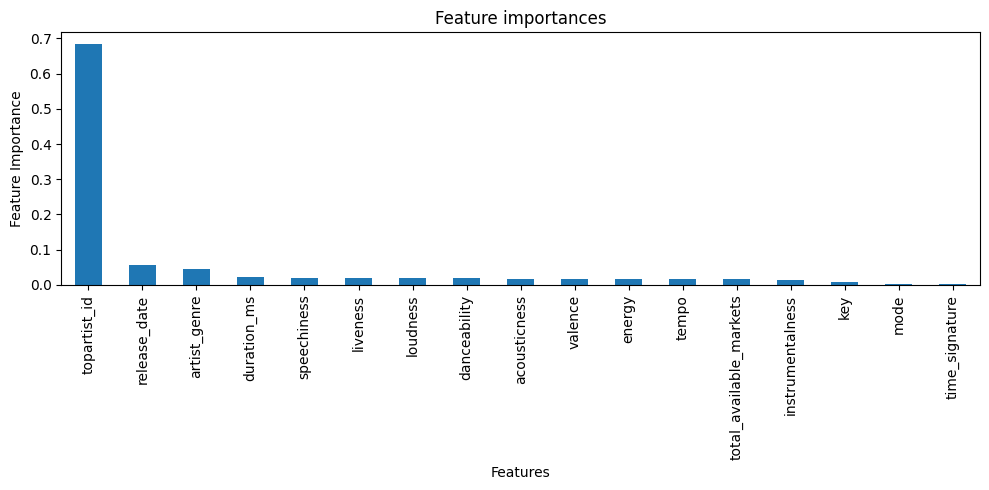

In [ ]:
importances = pd.Series(vanilla_rr.feature_importances_, 
                        index=feature_columns).sort_values(ascending=False)
print(importances)

# Create a chart
fig, ax = plt.subplots(figsize=(10,5))
importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
fig.tight_layout()

## Random Greid Search

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=50, num=5)]
max_depth = [int(x) for x in np.linspace(5, 15, num=5)]
#min_samples_split = [int(x) for x in np.linspace(5, 15, num=5)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,}
               #'min_samples_split': min_samples_split}

print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [5, 7, 10, 12, 15]}


In [ ]:
rf_model = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_model, 
                               param_distributions = random_grid, 
                               n_iter=5, cv=5, verbose=2, 
                               random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 40, 'max_depth': 15}

## Best Hyperparameter

In [ ]:
model = rf_random.best_estimator_

print("{:<15} {}".format('Train R^2:', round(model.score(X_train, y_train),4)))
print("{} {}".format('Validation R^2:', round(model.score(X_val, y_val),4)))
print("{:<15} {}".format('Test R^2:', round(model.score(X_test, y_test),4)))
print("{:<15} {}".format('MSE Score:', round(mean_squared_error(y_test, model.predict(X_test)),4)))

Train R^2:      0.8148
Validation R^2: 0.5883
Test R^2:       0.5875
MSE Score:      145.94


## Feature Impoartances with Best Hyperparameter

topartist_id               0.817749
release_date               0.078989
artist_genre               0.041398
total_available_markets    0.011515
duration_ms                0.007693
speechiness                0.006405
acousticness               0.005325
loudness                   0.005262
instrumentalness           0.005245
liveness                   0.005085
danceability               0.004193
valence                    0.003629
energy                     0.003356
tempo                      0.002663
key                        0.001010
time_signature             0.000244
mode                       0.000238
bias                       0.000000
dtype: float64


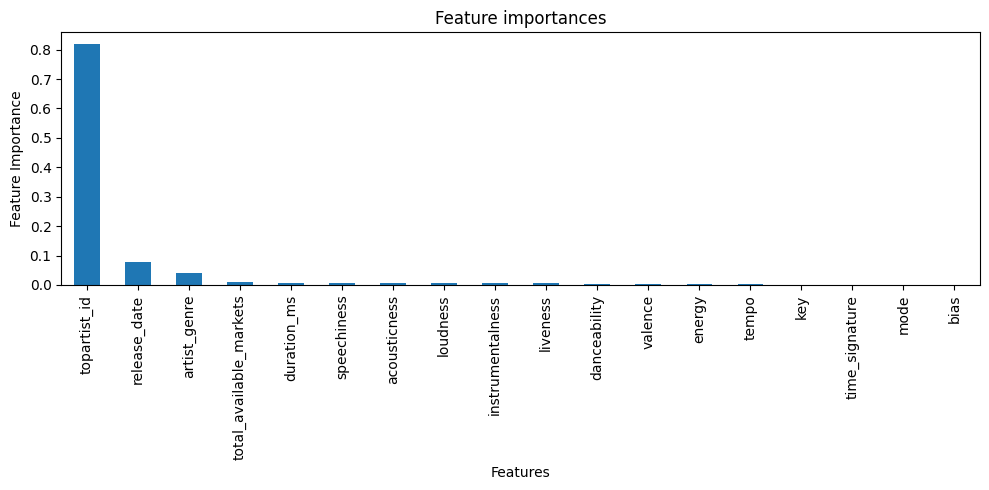

In [ ]:
importances = pd.Series(model.feature_importances_, 
                        index=feature_columns).sort_values(ascending=False)
print(importances)

# Create a chart
fig, ax = plt.subplots(figsize=(10,5))
importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
fig.tight_layout()

In [ ]:
model_1 = RandomForestRegressor(n_estimators=200, max_depth=25).fit(X_train, y_train)

In [ ]:
print("{:<15} {}".format('Train R^2:', round(model_1.score(X_train, y_train),4)))
print("{} {}".format('Validation R^2:', round(model_1.score(X_val, y_val),4)))
print("{:<15} {}".format('Test R^2:', round(model_1.score(X_test, y_test),4)))
print("{:<15} {}".format('MSE Score:', round(mean_squared_error(y_test, model_1.predict(X_test)),4)))

Train R^2:      0.9427
Validation R^2: 0.6158
Test R^2:       0.6153
MSE Score:      136.1254


topartist_id               0.681026
release_date               0.081833
artist_genre               0.046884
duration_ms                0.020110
speechiness                0.018389
loudness                   0.017710
liveness                   0.017091
acousticness               0.016992
danceability               0.016444
valence                    0.015494
total_available_markets    0.015331
tempo                      0.014769
energy                     0.014405
instrumentalness           0.013152
key                        0.007405
mode                       0.001622
time_signature             0.001343
bias                       0.000000
dtype: float64


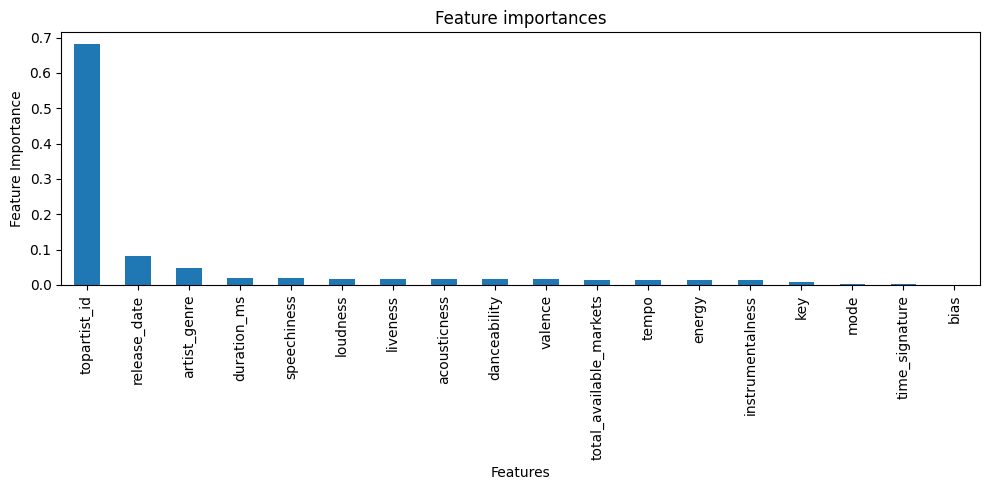

In [ ]:
importances = pd.Series(model_1.feature_importances_, 
                        index=feature_columns).sort_values(ascending=False)
print(importances)

# Create a chart
fig, ax = plt.subplots(figsize=(10,5))
importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
fig.tight_layout()

In [ ]:
# Your Code Here

smote = SMOTE(random_state=42)
X_dev_smote, y_dev_smote = smote.fit_resample(X_dev_scaled, y_dev)

print("Original Dataset shape: {:>18}".format(str(X_dev_scaled.shape)))
print("Dataset shape after sampling: {}".format(str(X_dev_smote.shape)))
print("")
print("Labels Distribution after sampling:")
y_dev_smote.value_counts()

In [ ]:
# Classification

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=5)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=5, n_estimators=50)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.12036756389120937


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

0.09849900797695366

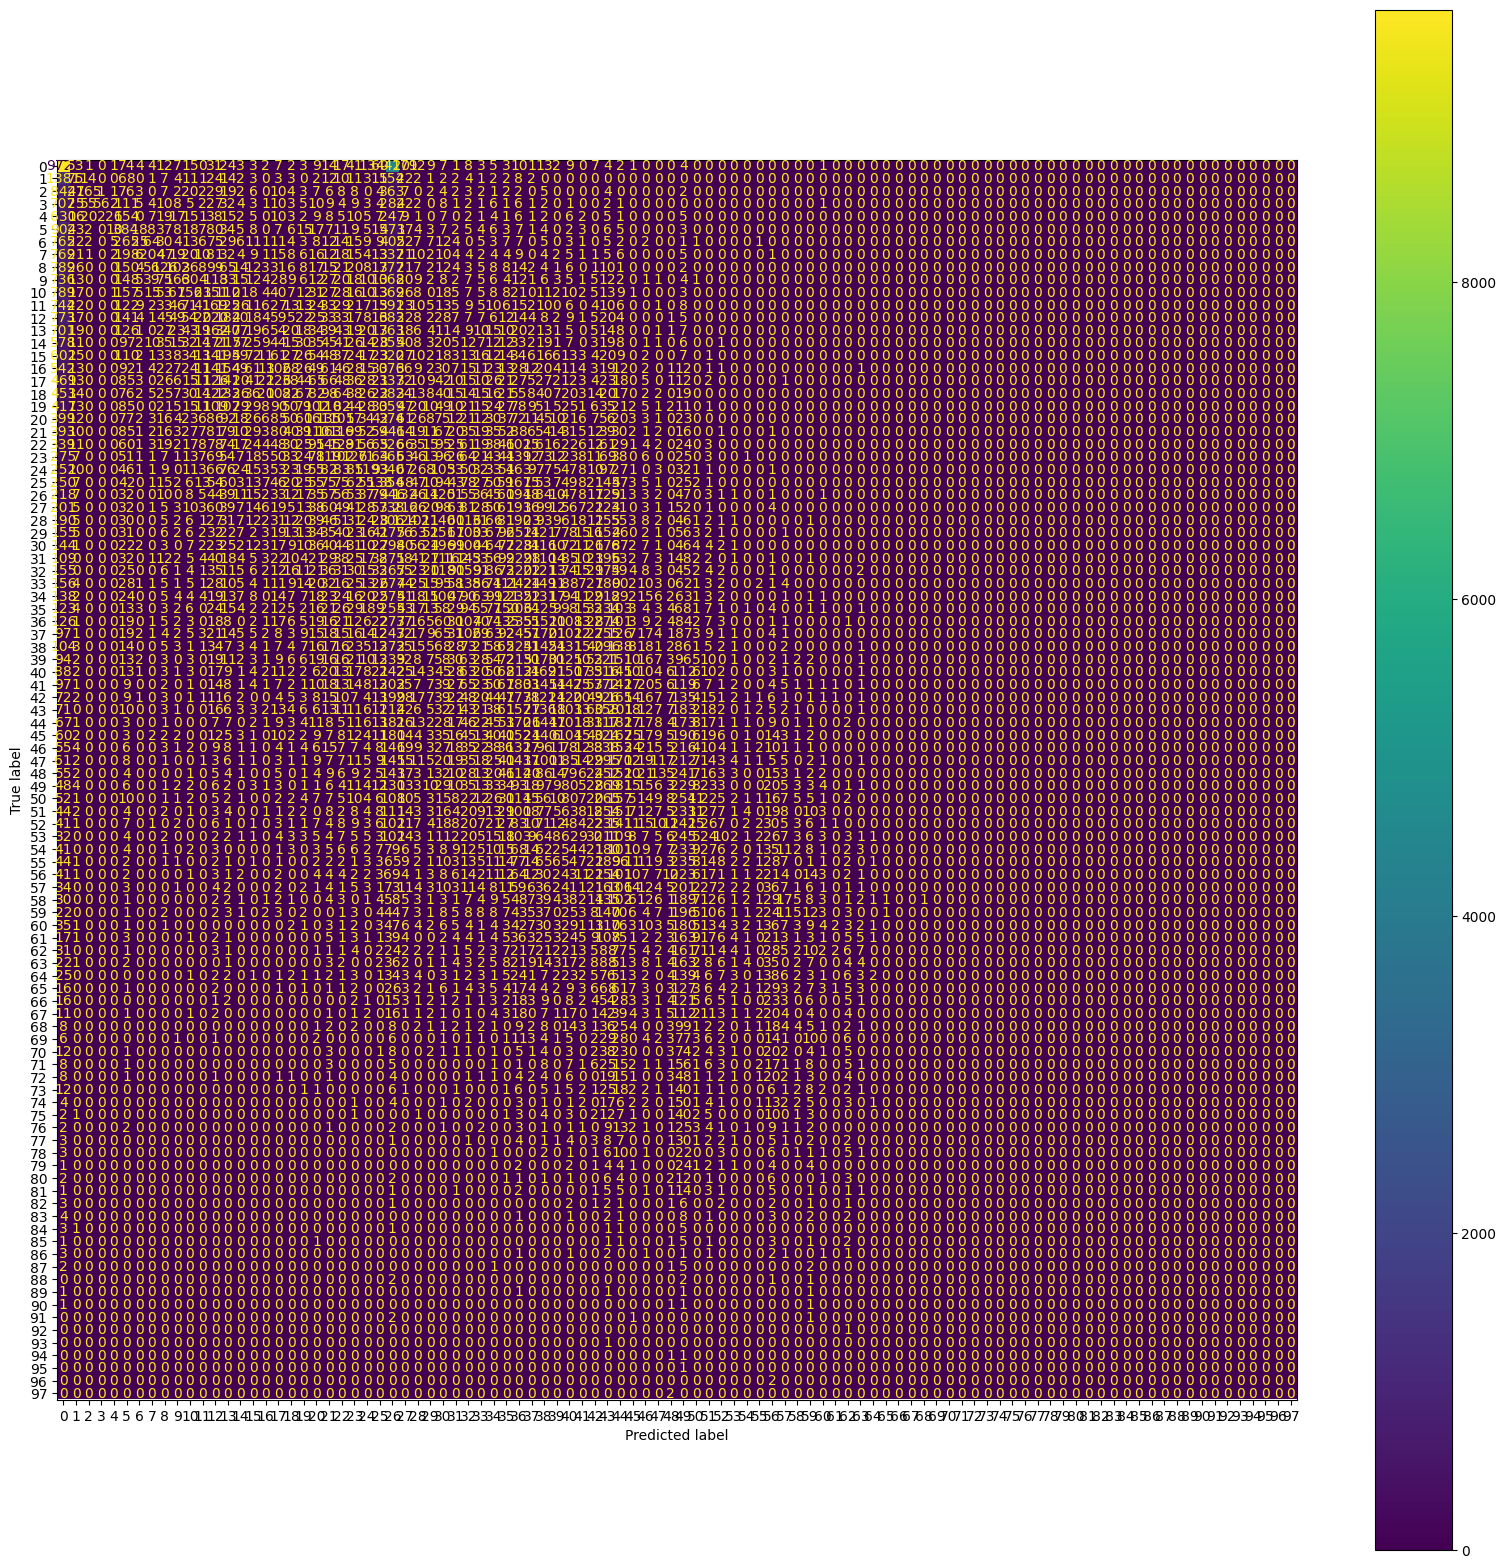

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(20,20))
#disp.plot(figsize=(20,20));
disp.plot(ax=ax)